**Consumer Theory for Cheap Information (Infinitely-divisible sampling)**

This simulation illustrates the main results from my paper "Consumer theory for cheap information" for the case where samples may be consumed in fractional amount (the decision-maker chooses an *expected* number of samples, then receives a Poisson draw of samples). The code relies on code from the discrete-sample file, so I recommend starting with that one.

# Code setup

First, we need to import a number of standard Python packages:

In [1]:
import numpy as np                   # Basic array stuff
import scipy.optimize as optim       # For finding function mins
from scipy.stats import multinomial  # Multinomial probability computation
from scipy.stats import poisson      # For poisson pmf computation
import scipy.optimize as optim       # For numerical optimization
import scipy.interpolate as interp   # For interpolating functions
import multiprocessing as mp         # For parallel processing
from pathos.multiprocessing import ProcessingPool
numcores = 12
from itertools import product        # Used for multidimensional function mapping
import matplotlib.pyplot as plt      # Plotting
from matplotlib import rc
from tabulate import tabulate        # For nicer printing of some data
from tqdm import tqdm   # Basic progress bar

Throughout this notebook, I'll be working with a 3 state decision problem.

In [2]:
numstates = 3

# Composite information sources and information values

## Defining information sources

Define information sources in the same way as the discrete-sampling case.

In [3]:
Qperfect = np.eye(numstates)   # Perfect information source

# Generate random experiments for testing
def rand_source(numstates, numrealizations):
    # generate a random array with the appropriate dimension
    Q = np.random.rand(numstates, numrealizations)
    # normalize so each row sums to 1
    for state in range(numstates):
        Q[state, :] = Q[state, :] / np.sum(Q[state, :])
    return Q

# Q1 = rand_source(numstates, 3)
# Q2 = rand_source(numstates, 3)

# Q12Values
Q1 = np.array([[0.07, 0.18, 0.75],
               [0.45, 0.19, 0.36],
               [0.45, 0.05, 0.50]])
Q2 = np.array([[0.42, 0.58],
               [0.63, 0.37],
               [0.03, 0.97]])

As before, we'll need to compute the composite experiment generated by observing the given number of samples from each experiment. We'll later take expecations over the possible sample draws.

In [4]:
# Compute appropriate partitions (returns a generator)
def partitions(n, numrealizations):
    if numrealizations == 1:
        if n >= 0:
            yield (n,)
        return
    for i in range(n+1):
        for result in partitions(n-i, numrealizations-1):
            yield (i,) + result


# Compute matrix for the n-sample source
def n_samples(Q, n):
    numstates = Q.shape[0]
    numrealizations = Q.shape[1]
    if n == 0:                   # return trivial experiment if 0 samples
        return np.ones((numstates, 1))
    QnT = []                     # transpose of Qn
    for outcome in partitions(n, numrealizations):
        outcomeprobs = []        # column of state-dep outcome probs
        for state_idx in range(numstates):
            # create a multinomial with the given outcome probs
            multinom = multinomial(n, Q[state_idx, :])
            outcomeprobs.append(multinom.pmf(outcome))
        QnT.append(outcomeprobs)
    Qn = np.array(QnT).T         # convert to array and transpose
    return Qn

In [5]:
def composite_source(Q1, Q2):
    numstates = Q1.shape[0]
    numrealizations = Q1.shape[1] * Q2.shape[1]
    Qcomp = np.empty((numstates, numrealizations))  # initialize output
    for state in range(numstates):
        # compute all possible combination probs with an outer product
        Qcomp[state, :] = \
            np.reshape(np.outer(Q1[state, :], Q2[state, :]),
                       (numrealizations))           # reshape to vect.
    return Qcomp

## Value of information

As before, we'll need to compute the value of information from observing a deterministic number of samples. We'll be taking expectations over these values later.

In [6]:
# example payoff matrix (payoff 1 only if choose the correct state
# plus an insurance action that always gives a low payoff)
U = np.eye(numstates)
# example prior vector (diffuse prior)
P = np.ones(numstates) / numstates

In [7]:
def info_value(Q, U, P):
    numrealizations = Q.shape[1]

    Upi = U @ np.diag(P)
    # compute (actions x realizations) matrix of payoff of each action
    # times unconditional prob of each realization
    Ua = Upi @ Q
    # choose best action for each message then sum across messages
    valuewithinfo = sum(np.amax(Ua, axis=0))
    return valuewithinfo

# Poissonized experiments

Consumer theory is messy when goods must be consumed in discrete samples. In order to simplify the analysis, it will be useful to have an infinitely divisible analog to samples. *Poissonizing* the experiments naturally accomplishes this.

Label the Poissonization of $\mathcal{E}$ as $\hat{\mathcal{E}}$. That is, $\hat{\mathcal{E}}$ is the experiment composed of a Poisson (with parameter 1) number of draws from $\mathcal{E}$. Because the sum of Poisson draws is itself Poisson with the sum of parameters, the Poisson parameter is an infinitely divisible analog of $\mathcal{E}$. Following the convention of the paper, I will call the expected number of samples, the *quantity* of information.

If $\mathcal{E}$ has efficiency index and precision $\rho$ and $\beta$ respectively, the Poissonization has index and precision given by
$$\hat{\rho} = e^{\rho-1}$$
$$\hat{\beta} = 1-\rho$$
So for noisy experiments ($\rho$ close to 1), the Poissonization will behave near identically at large samples.

We want to be able to compute the value of information for a Poissonized experiment. Mathematically, this is simple:

$$\hat{v}(q_{1},q_{2}) = \sum_{n_{1}=0}^{\infty} \sum_{n_{2}=0}^{\infty} \frac{q_{1}^{n_{1}} e^{-q_{1}}}{n_{1}}\frac{q_{2}^{n_{2}} e^{-q_{2}}}{n_{2}} v(n_{1},n_{2})$$

Because computing info values for high sample sizes is numerically taxing, we'll precompute the values for all sample combinations up to some relatively high sample size. So long as the Poisson parameters are no more than a third of this max (so the ommited values are more than 2 standard deviations from the mean), we should get a pretty good approximation.

Computing all these values takes a very long time (multiple days, even when heavily parallelized).

In [8]:
# Upper bound of grid
Nmax = 600

# Create dummy functions for the sample size mapping
def Q1_n_samples(n1):
    return n_samples(Q1, n1)
def Q2_n_samples(n2):
    return n_samples(Q2, n2)
# Compute lists of n-sample matrices for each in parallel
pool = ProcessingPool(nodes=numcores)
Q1ns = pool.map(Q1_n_samples, np.arange(Nmax))
Q2ns = pool.map(Q2_n_samples, np.arange(Nmax))

In [9]:
# Create a dummy function for the value mapping
# Takes a single argument since the mapping passes the 
# sample sizes as a tuple
def Q12_value(n1, n2):
    Q12n = composite_source(Q1ns[n1], Q2ns[n2])
    return info_value(Q12n, U, P)

# Compute array of values on the Nmax x Nmax grid in parallel
# To save memory, only parallelize one dimension
Q12Values = []
for n1 in tqdm(range(Nmax)):  # tqdm shows a basic progress bar
    pool.restart()
    value_n1 = lambda n2 : Q12_value(n1, n2)
    Q12Valuesn1 = pool.map(value_n1, range(Nmax))
    Q12Values.append(Q12Valuesn1)

# The above produces a big list. 
# Reshape this into a Nmax x Nmax grid
Q12Values = np.reshape(Q12Values, (Nmax, Nmax))

100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


Since that took forever, save the computed values for loading later:

In [16]:
#with open('Q12Values2.npy', 'wb') as file:
#    np.save(file, Q12Values)

In [8]:
with open('Q12Values.npy', 'rb') as file:
    Q12Values = np.load(file)

In [9]:
# Compute the Poissonized value
def poisson_value(q1, q2, Q12Values):
    n1max = Q12Values.shape[0]
    n2max = Q12Values.shape[1]
    poissonprobs1 = poisson.pmf(np.arange(n1max), q1)
    poissonprobs2 = poisson.pmf(np.arange(n2max), q2)
    probsmatrix = np.outer(poissonprobs1, poissonprobs2)
    value = np.sum(probsmatrix * Q12Values)
    return value

# Plotting indifference curves

Now we want to compare the approximate MRS to the true MRS. First we need function to quickly compute the component precisions of a composite experiment with fractions $r$. We'll do this by computing the efficiency indices for regular experiments, then using $\hat{\beta} = 1 - \rho$ as the precision for the Poissonized version.

In [10]:
# return the component precision for each test at the w composite factor
def comp_precision(Q1, Q2, r):
    numstates = Q1.shape[0]
    # loop over pairs of states
    rho = 0
    for state1 in range(numstates):
        for state2 in range(state1+1, numstates):
            # Define the Hellinger transform for the given dichotomy
            def llrmgf1(t):
                Q1state1_t = Q1[state1, :]**t
                Q1state2_t = Q1[state2, :]**(1-t)
                return np.sum(Q1state1_t*Q1state2_t)

            def llrmgf2(t):
                Q2state1_t = Q2[state1, :]**t
                Q2state2_t = Q2[state2, :]**(1-t)
                return np.sum(Q2state1_t*Q2state2_t)

            def compllrmgf(t):
                # Since we are using the poissonization, the MGF is e^(M-1)
                return np.exp(llrmgf1(t)-1)**r * np.exp(llrmgf2(t)-1)**(1-r)

            # Compute efficiency index for the dichotomy
            optimizer = optim.minimize(compllrmgf, 0.5)
            rhopair = optimizer.fun
            taupair = optimizer.x
            # if new rho is worse (higher), store it
            if rho < rhopair:
                rho = rhopair
                # Store component rhos
                rho1r = llrmgf1(taupair)
                rho2r = llrmgf2(taupair)
    # Return the precision for the Poissonized experiments
    return -np.log(rho1r), -np.log(rho2r)

# return total precision for a composite factor r
def total_precision(Q1, Q2, r):
    beta1r, beta2r = comp_precision(Q1, Q2, r)
    return r*beta1r + (1-r)*beta2r

We can then compute an approximate indifference curve by plotting an iso-precision lines. The following function finds the locus of points with total least precision equal to the given quantity from $\mathcal{E}_1$.

In [11]:
def iso_least_precision(q1, q2, Q1, Q2):
    dq = 0.1
    tol = 0.05
    rstart = q1 / (q1+q2)
    startprecision = (q1+q2) * total_precision(Q1, Q2, rstart)   # precision of initial sample bundle
    # Find corners
    maxq1 = startprecision / total_precision(Q1, Q2, 1)
    maxq2 = startprecision / total_precision(Q1, Q2, 0)
    q1points = np.arange(0, maxq1, dq)
    q2points = []
    # for each n1, find n2 that gives the right precision
    for q1loop in q1points:
        netprecision = lambda q2dummy : startprecision - (q1loop+q2dummy)*total_precision(Q1, Q2, q1loop/(q1loop+q2dummy))
        # Divide and conquer
        q2upper = maxq2
        q2lower = 0
        while np.abs(q2upper-q2lower) > tol:
            q2mid = (q2upper + q2lower)/2
            if netprecision(q2mid) > 0: q2lower = q2mid
            else: q2upper = q2mid
        q2points.append(q2mid)
    q2points = np.array(q2points)
    return q1points, q2points     

Plot a few indifference curves. We'll compare these to exactly computed indifference curves next. (Remember: for accurate results, don't use quantities higher than about a third of the max sample size that was precomputed earlier!)

In [12]:
q1starts = [30, 170, 340]
#q1starts = [45, 220, 400]
q1ilps, q2ilps = [], []
for q1start in q1starts:
    q1points, q2points = iso_least_precision(q1start,0 ,Q1, Q2)
    q1ilps.append(q1points)
    q2ilps.append(q2points)

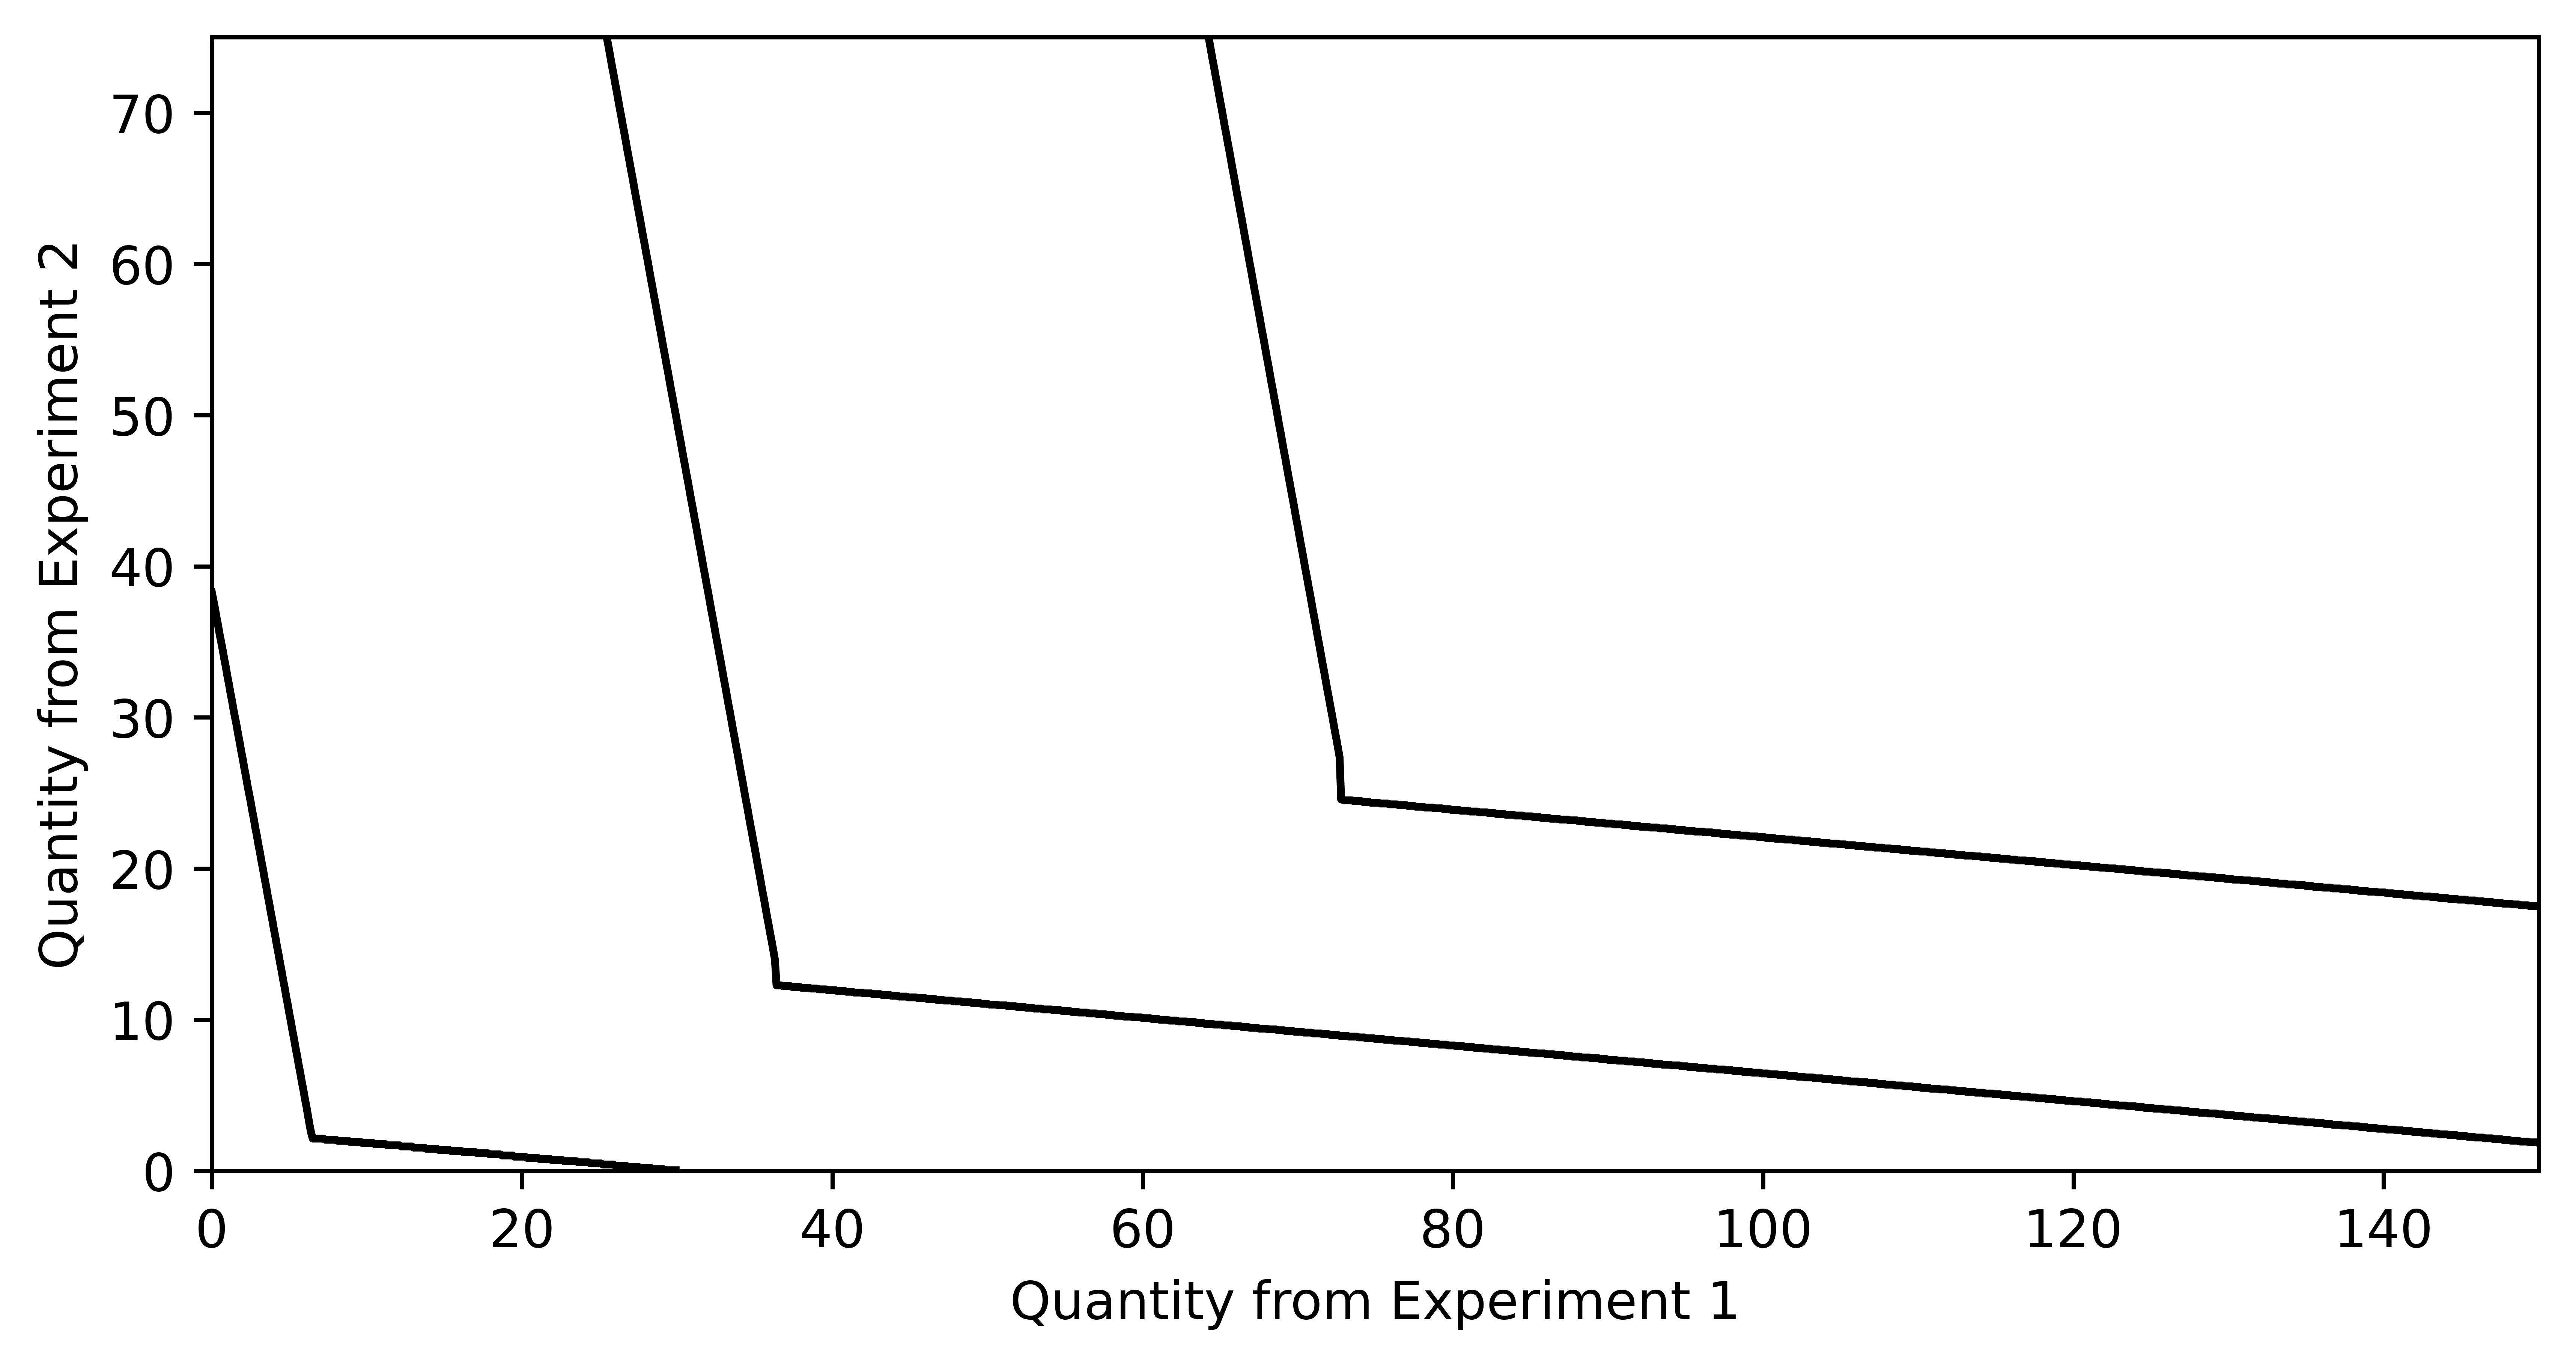

In [13]:
fig = plt.figure(figsize=(8, 4), dpi=1000)
ax = fig.add_subplot(1,1,1)
ax.set_xlim((0, 150))
ax.set_ylim((0, 75))
ax.set_xlabel('Quantity from Experiment 1')
ax.set_ylabel('Quantity from Experiment 2')
for i in range(len(q1ilps)):
    ax.plot(q1ilps[i], q2ilps[i], 'k')

In [14]:
def iso_precision(precision, state1, state2, Q1, Q2):
    dr = 0.0005
    numstates = Q1.shape[0]
    # restrict both tests to the dichotomy of interest
    Q1d = Q1[[state1,state2],:]
    Q2d = Q2[[state1,state2],:]
    q1points, q2points = [], []
    for r in np.arange(0,1+dr,dr):
        total_q = precision / total_precision(Q1d, Q2d, r)
        q1points.append(r*total_q)
        q2points.append((1-r)*total_q)
    return q1points, q2points
    
numdichotomies = int((numstates * (numstates-1))/2)
# empty matrix for n2 points for each iso-precision line
isoprecq1points = []
isoprecq2points = []
startprecision = q1starts[0]*total_precision(Q1, Q2, 1)
for state1 in range(numstates):
    for state2 in range(state1+1, numstates):
        q1points, q2points = iso_precision(startprecision, state1, state2, Q1, Q2)
        isoprecq1points.append(q1points)
        isoprecq2points.append(q2points)

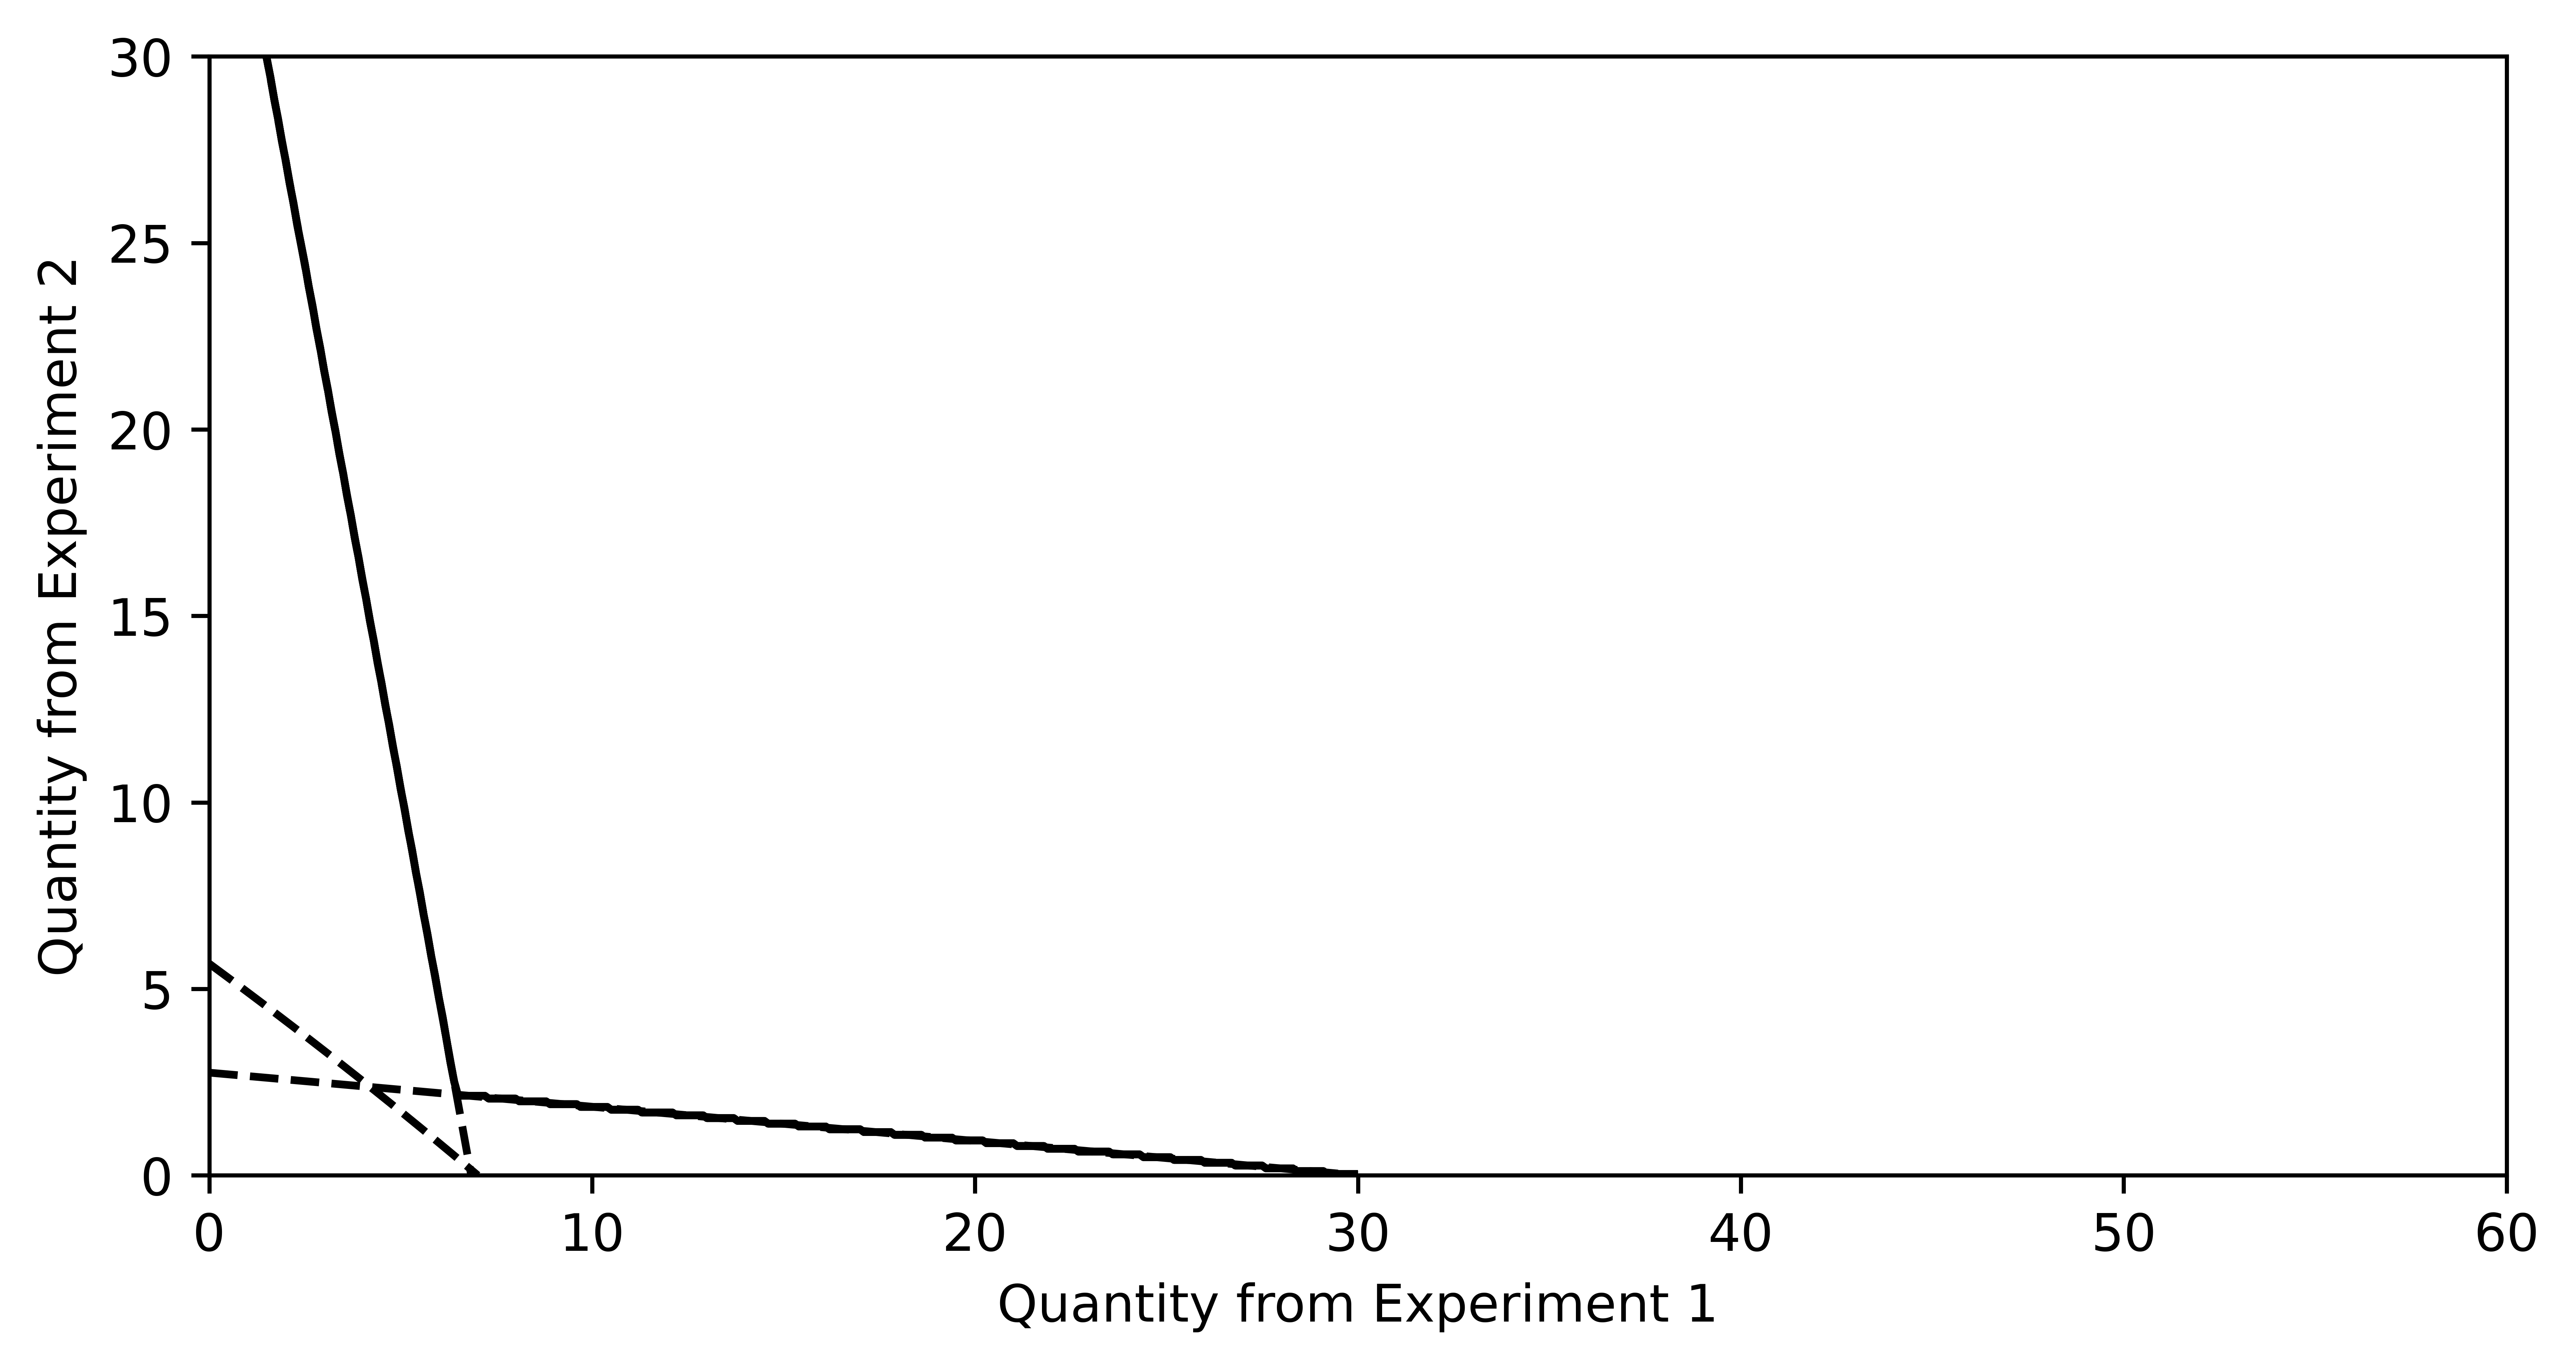

In [15]:
fig = plt.figure(figsize=(8,4), dpi=1000)
ax = fig.add_subplot(1,1,1)
ax.set_xlim((0, 60))
ax.set_ylim((0, 30))
ax.set_xlabel('Quantity from Experiment 1')
ax.set_ylabel('Quantity from Experiment 2')
for dichotomy in range(numdichotomies):
    ax.plot(isoprecq1points[dichotomy], isoprecq2points[dichotomy], '--k');
    ax.plot(q1ilps[0], q2ilps[0], 'k');

In [16]:
# Find q1 corner that does just better than given bundle
def just_better_corner(q1init,q2init):
    tol = 0.001
    startval = poisson_value(q1init, q2init, Q12Values)    # value of initial sample bundle
    # First find the n1 corner just better
    # We'll use this as our starting point
    q1running = q1init
    currentval = 0
    # do a quick and dirty midpoint method
    # increase sample size until something does better
    while currentval < startval:
        q1running = 1.10*q1running
        currentval = poisson_value(q1running, 0, Q12Values)
    q1upper = q1running
    q1lower = (1/1.10)*q1running
    # split until within tolerance
    while np.abs(q1upper-q1lower) > tol:
        q1mid = (q1upper+q1lower)/2
        currentval = poisson_value(q1mid, 0, Q12Values)
        if currentval > startval: 
            q1upper = q1mid
        else:
            q1lower = q1mid
    return q1mid

def indifference_curve(q1init, q2init):
    # At larger scale, can be less precise
    #q1step = 0.1
    q1step = 0.01 * np.log(q1init+q2init)
    dq = 0.1
    startval = poisson_value(q1init, q2init, Q12Values)    # value of initial sample bundle
    # First find the q1 corner just better
    # We'll use this as our starting point
    if q2init > 0:
        q1start = just_better_corner(q1init, q2init)
    else: q1start = q1init
    # Trace out the lower extent of the UCS
    q2 = 0      # start with no samples from Q2
    q1points = []
    q2points = []
    for q1loss in np.arange(0, q1start, q1step):
        q1 = q1start - q1loss
        q1points.append(q1)
        # find minimum quantity from Q2 to make better off
        currentval = 0
        while currentval < startval:
            q2 = q2 + dq
            currentval = poisson_value(q1, q2, Q12Values)
        q2points.append(q2-0.5*dq)
        q2 = q2 - dq     # decr. nq just to be sure later
    # fill in corner
    q1points.append(0)
    currentval = 0
    while currentval < startval:
        q2 = q2 + dq
        currentval = poisson_value(0, q2, Q12Values)
    q2points.append(q2)
    return q1points, q2points

In [17]:
q1ics, q2ics = [], []
for q1start in q1starts:
    value = poisson_value(q1start, 0, Q12Values)
    q1points, q2points = indifference_curve(q1start, 0)
    q1ics.append(q1points)
    q2ics.append(q2points)

We can now plot the true indifference curves with the approximate ones:

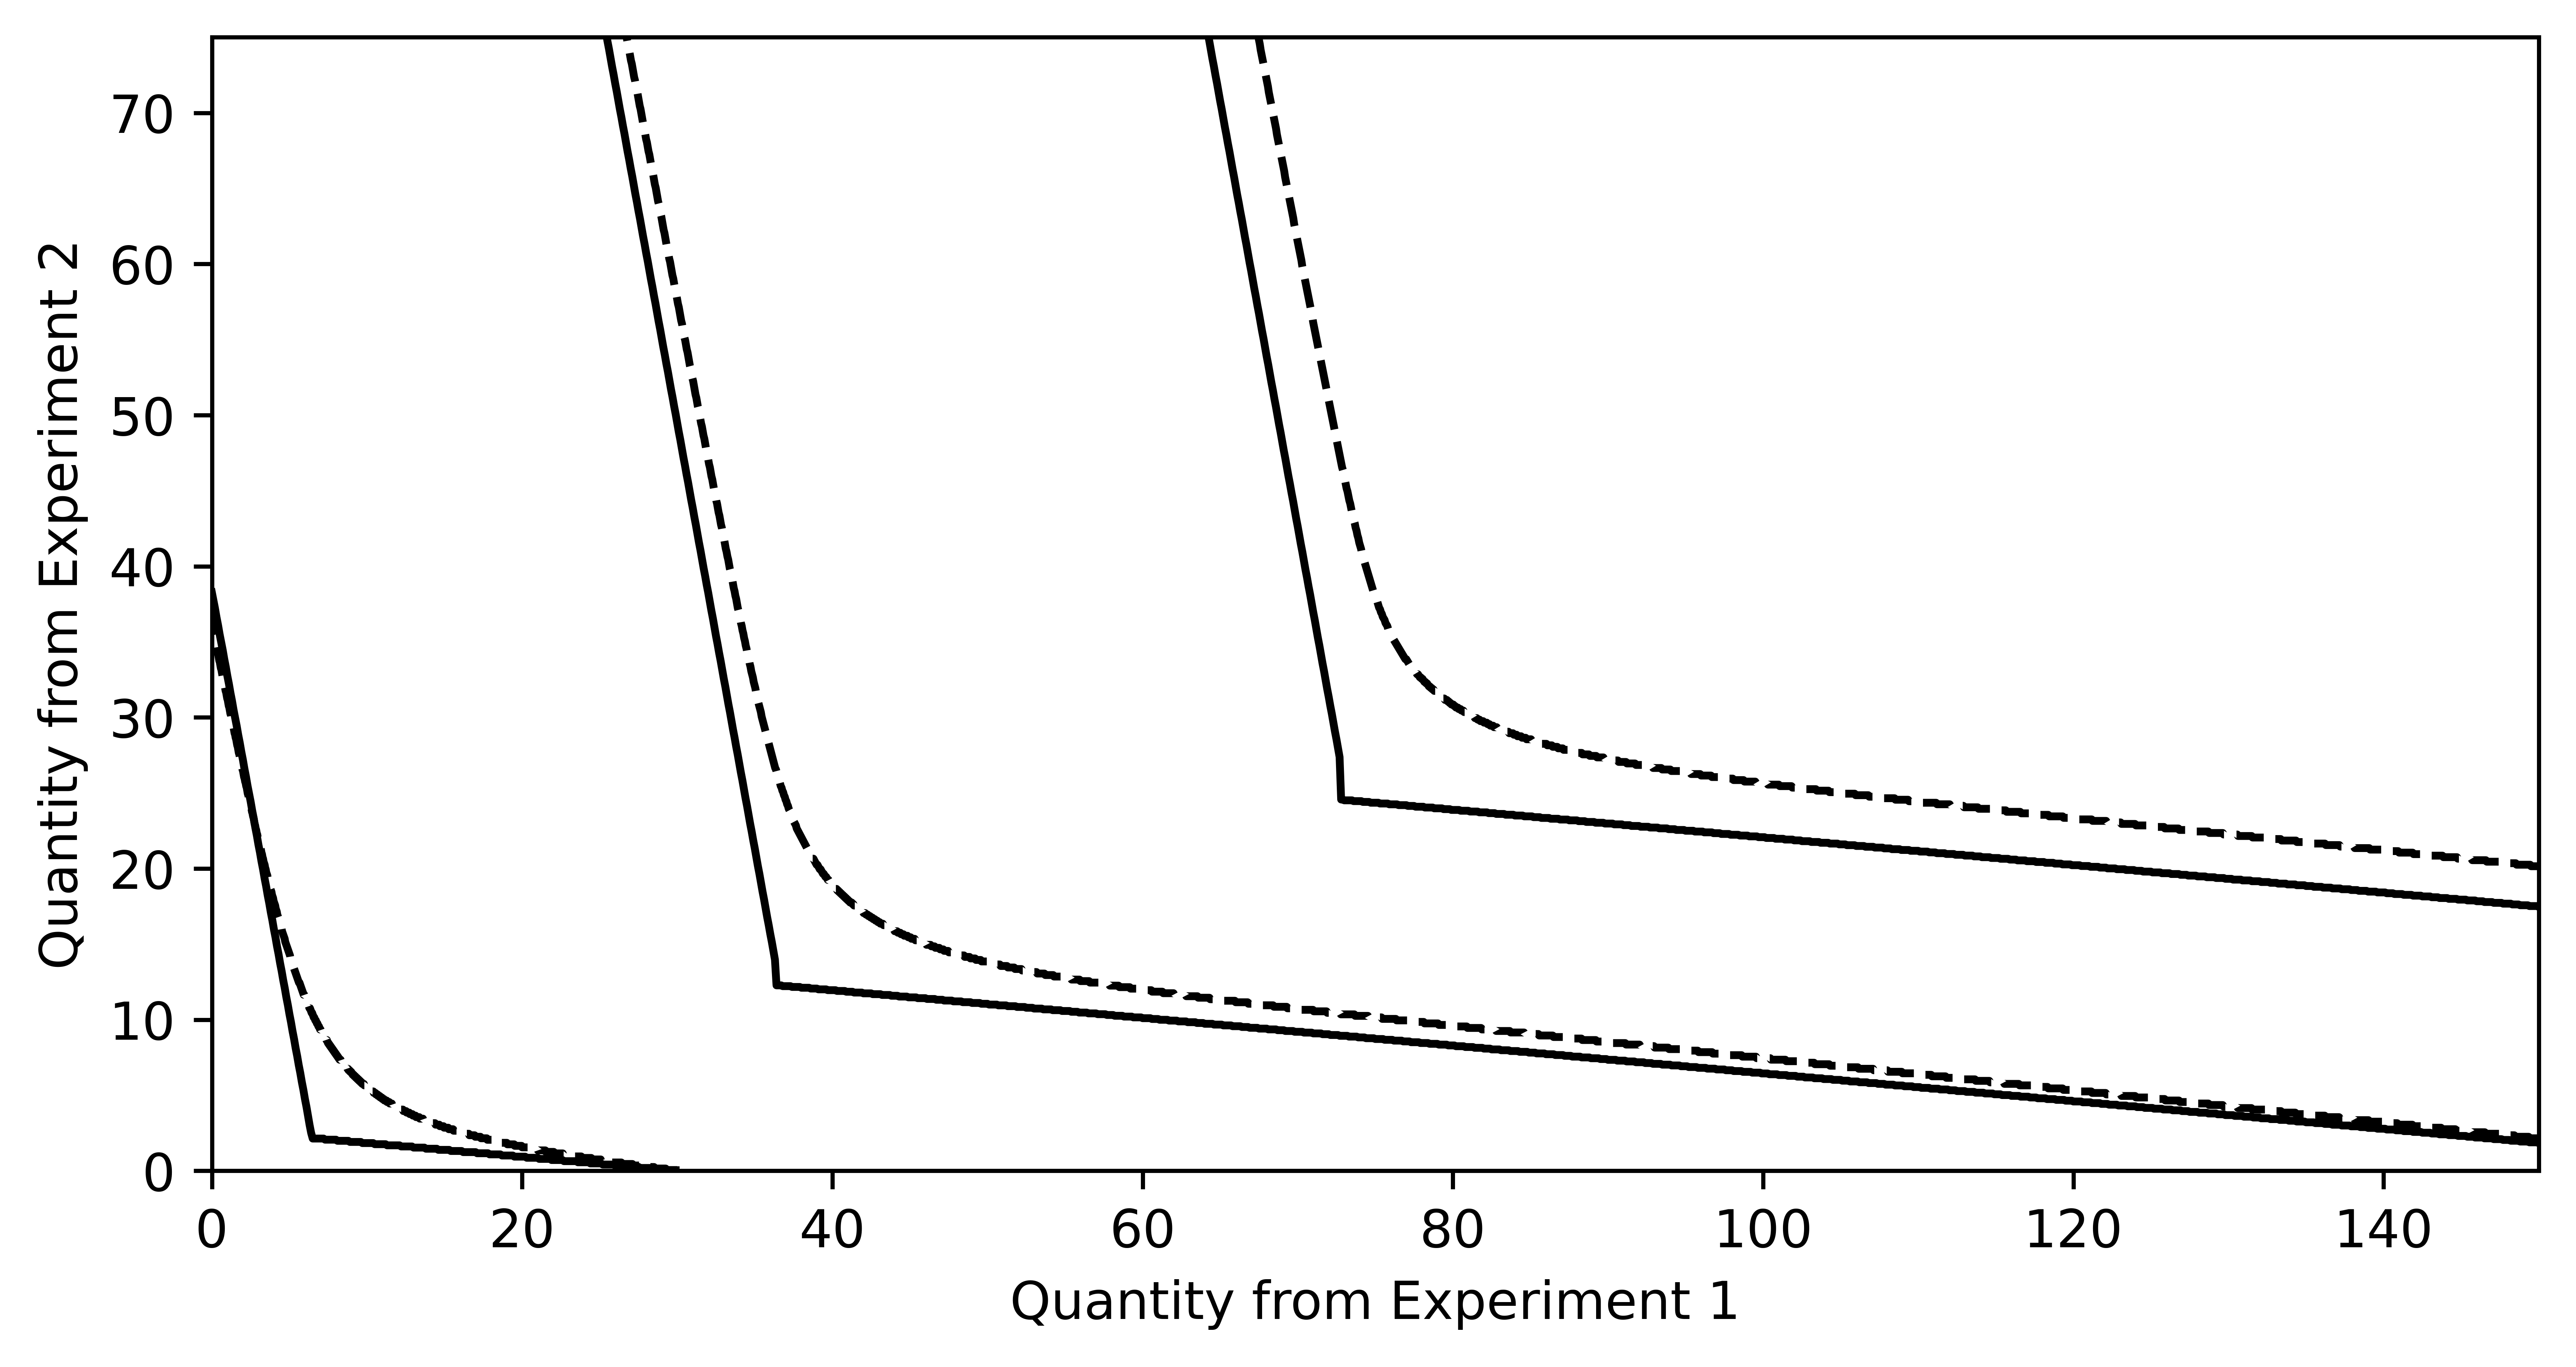

In [18]:
fig = plt.figure(figsize=(8, 4), dpi=1000)
ax = fig.add_subplot(1,1,1)
ax.set_xlim((0, 150))
ax.set_ylim((0, 75))
ax.set_xlabel('Quantity from Experiment 1')
ax.set_ylabel('Quantity from Experiment 2')
for i in range(len(q1ics)):
    ax.plot(q1ics[i], q2ics[i], '--k',
            q1ilps[i], q2ilps[i], 'k');
# plt.savefig('fig.png')

# Income expansion paths

Now we want to plot some income expansion paths. First, we'll compute the true demand for a variety of income levels, then plot the UC sets for those demand points, against their iso-precision lines.

In order to reduce the computational complexity of finding demand, we can restrict the search to a region around the maxi-min precision proportions. First, we find all kinks/corners by finding points where the slope of the iso-precision line falls in magnitude.

In [19]:
# compute mrs by composite factor, find kinks
mrs = []
dr = 0.01
rgrid = np.arange(0, 1, dr)
kinks = [0, 1]
for r in rgrid:
    beta1r, beta2r = comp_precision(Q1, Q2, r)
    mrs.append(beta1r/beta2r)
    if r > dr and mrs[-1] < mrs[-2] - 0.001:    # mrs only falls at kink points
        kinks.append(r)

print(tabulate([["Kinks at composite factors:"] + kinks]))
#plt.plot(wgrid, mrs);

---------------------------  -  -  ----
Kinks at composite factors:  0  1  0.74
---------------------------  -  -  ----


Given a selection of sample proportions (the kinks and corners), for a given set of prices, we can find the one with best least precision per dollar. We can then search for the optimal sample bundle in the region around this point. Provided the search region is large enough, we will find the true optimal bundle.

In [20]:
def demand(Y, c1, c2, kinks, epsilon):
    dq = 0.05
    # first find maxi-min precision per dollar
    ppd0 = 0
    for r in kinks: 
        ppd1 = total_precision(Q1, Q2, r) / (r*c1 + (1-r)*c2)
        if ppd1 > ppd0:
            ppd0 = ppd1
            rstar = r
    # maxi-min precision bundle under budget Y is
    total_q = Y / (rstar*c1 + (1-rstar)*c2)
    q1star, q2star = rstar*total_q, (1-rstar)*total_q
    # Candidate bundles are the feasible bundles with q1 within epsilon
    # of the maxi-min precision bundle (q1star,q2star) and are affordable
    value = 0
    q1Lbar = max(0, q1star-epsilon)       # lowest q1 can't be negative
    q1Ubar = min(q1star+epsilon, Y/c1)   # biggest q1 must be affordable
    for q1 in np.arange(q1Lbar, q1Ubar+dq, dq):
        q2 = (Y - (c1*q1)) / c2  # highest affordable n2
        # compute value bundle
        checkvalue = poisson_value(q1, q2, Q12Values)
        # check if value is higher than previous best and store if so
        if checkvalue > value:    
            value = checkvalue
            q1best, q2best = q1, q2
    
    return q1best, q2best

In [21]:
# prices
priceratios = [1/6, 1, 4]

# create cost vectors with given cost ratios
# with minimum cost always 1
c1s, c2s = [], []
for pr in priceratios:
    if pr < 1:
        c1s.append(1)
        c2s.append(1/pr)
    else:
        c1s.append(pr)
        c2s.append(1)

budgets = np.logspace(np.log(2), np.log(1500), num=50, base=np.exp(1))
#budgets = [10,20,30]

# Also compute the maxi-min precision ratio
rstar = []
for i in range(len(c1s)):
    ppds = [total_precision(Q1, Q2, r) / (r*c1s[i] + (1-r)*c2s[i]) for r in kinks]
    rstar.append(kinks[ppds.index(max(ppds))])

In [22]:
yexpansion1, yexpansion2 = [], []
for i in range(len(c1s)):
    q1demand, q2demand = [], []
    for Y in budgets:
        q1, q2 = demand(Y, c1s[i], c2s[i], kinks, 500)
        q1demand.append(q1)
        q2demand.append(q2)
    yexpansion1.append(q1demand)
    yexpansion2.append(q2demand)

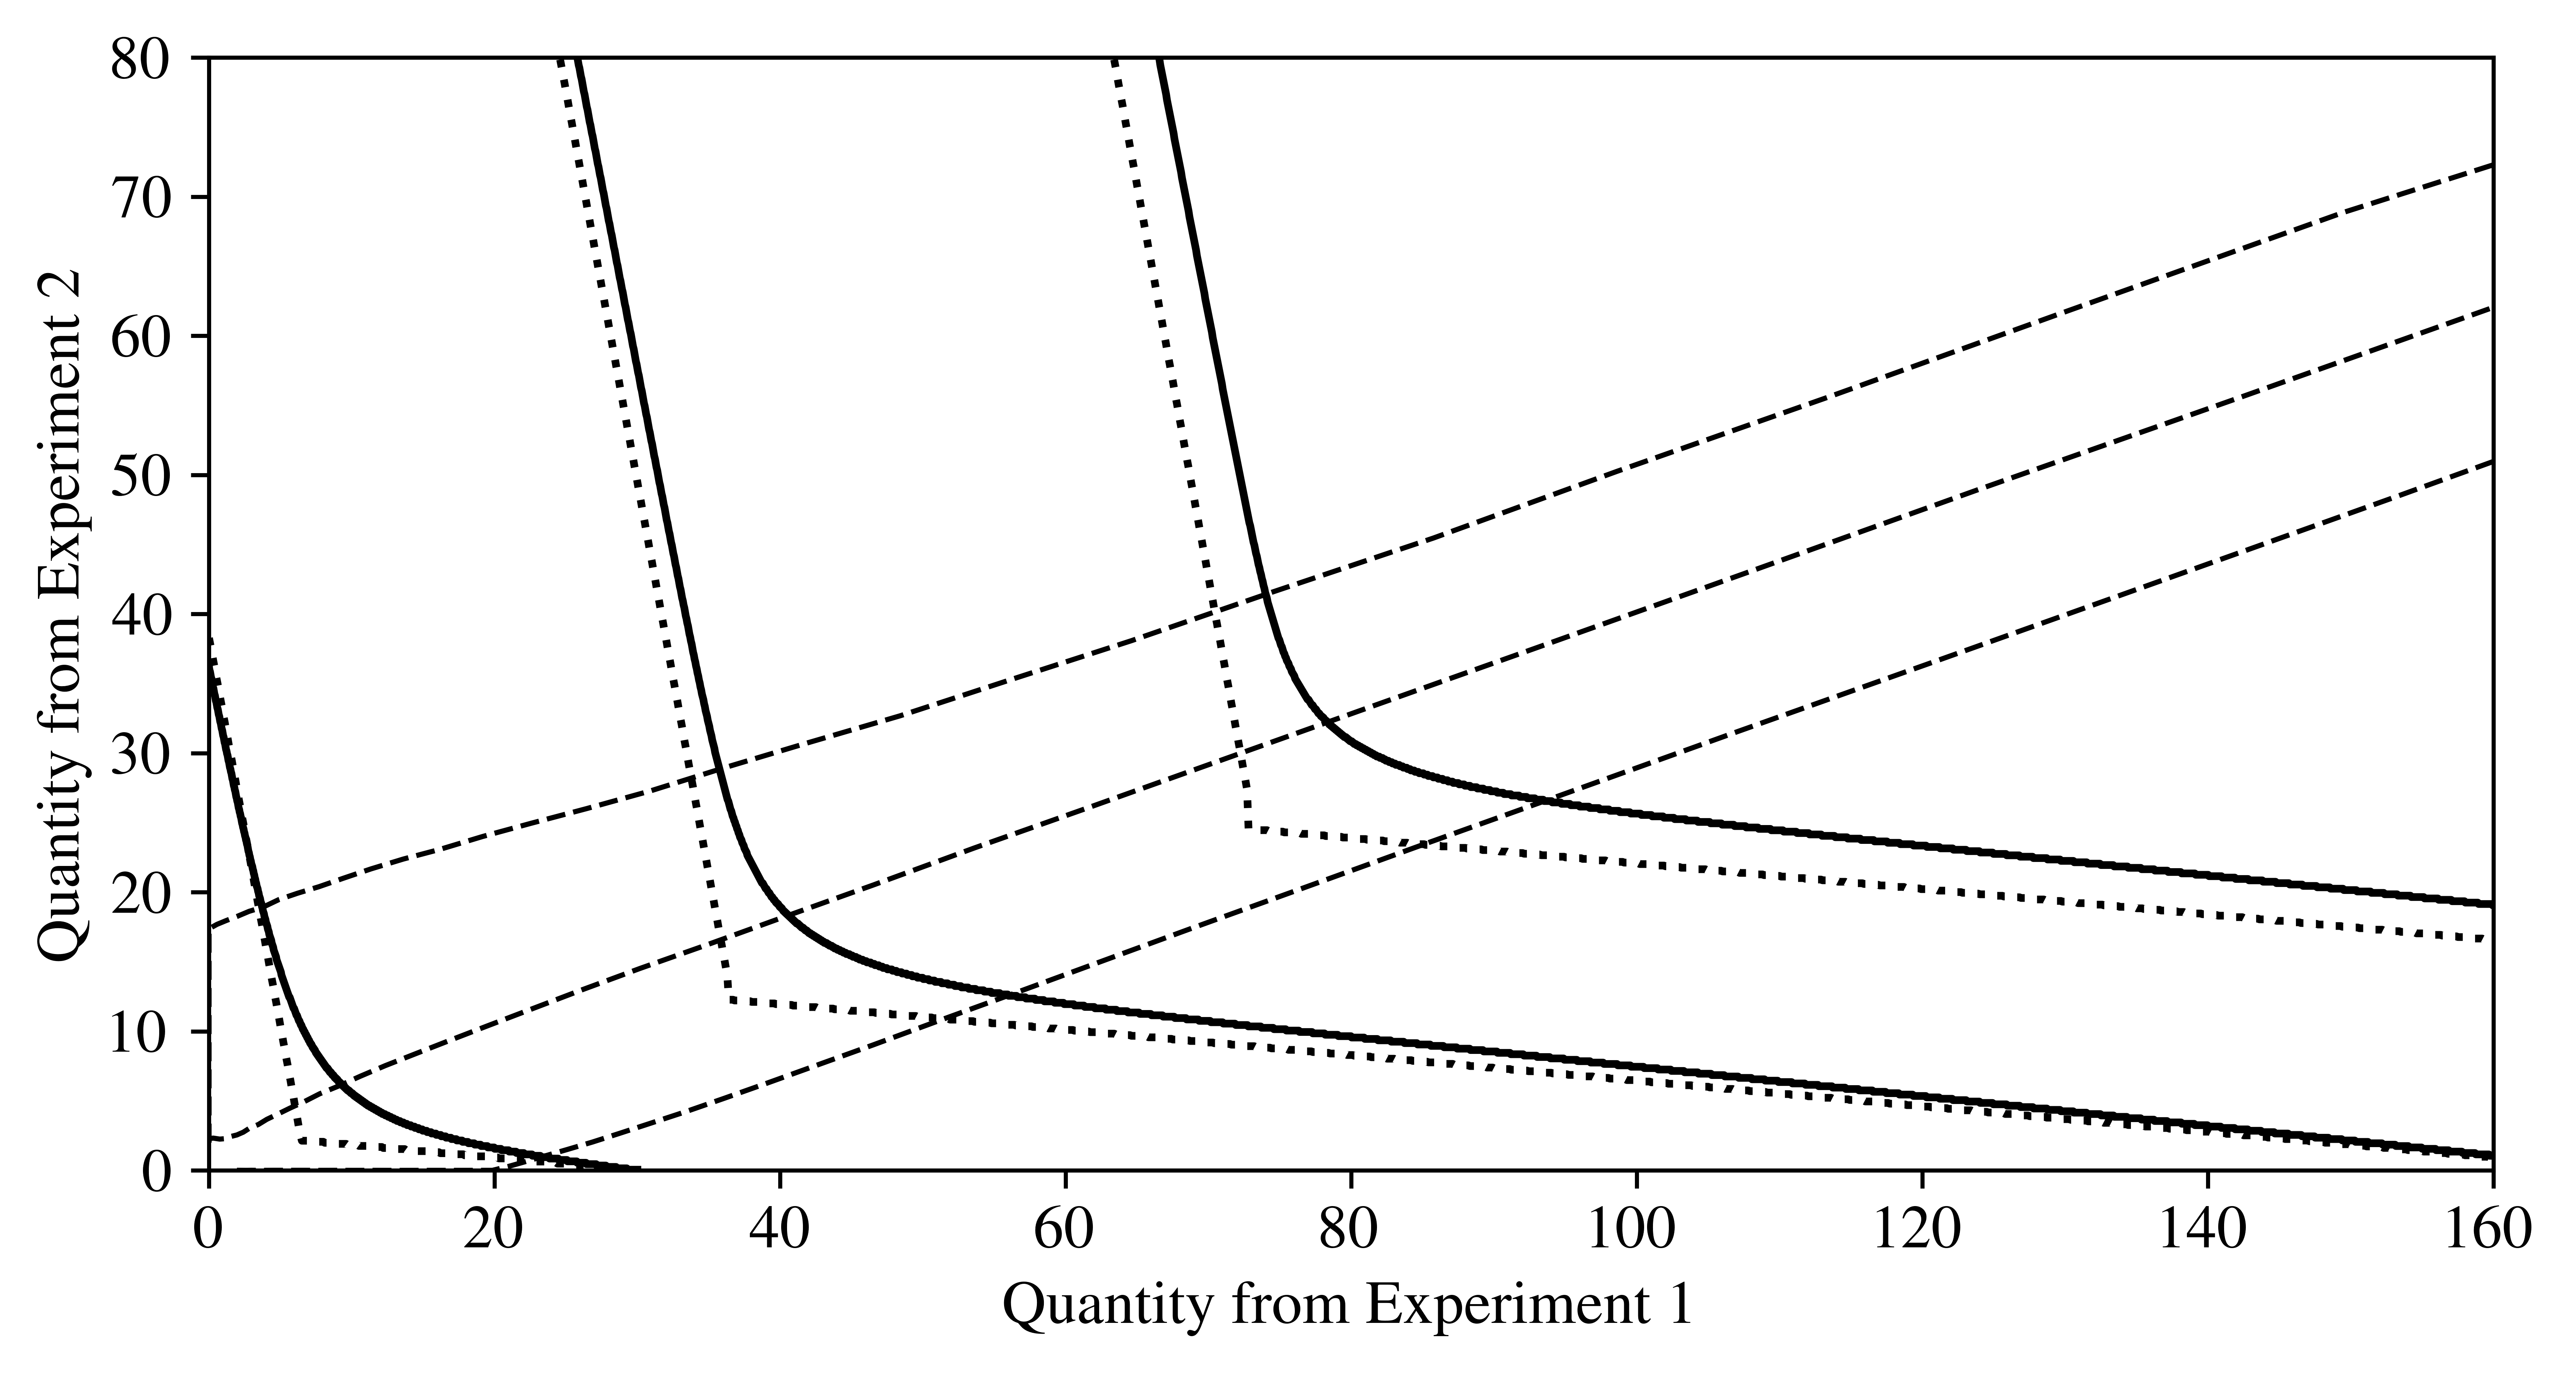

In [23]:
fig = plt.figure(figsize=(8,4), dpi=1000)
# set matching font
fontProperties = {'family':'serif','serif':['Times'],
    'weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
ax = fig.add_subplot(1,1,1)
ax.set_xlim((0, 160))
ax.set_ylim((0, 80))
ax.set_xlabel('Quantity from Experiment 1')
ax.set_ylabel('Quantity from Experiment 2')
for i in range(len(yexpansion1)):
    ax.plot(yexpansion1[i], yexpansion2[i], '--k', linewidth=1);
    
for i in range(len(q1ics)):
    ax.plot(q1ics[i], q2ics[i], '-k',
            q1ilps[i], q2ilps[i], ':k');

plt.savefig('poissonincexp.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0,transparent=True)

## Demand for information

Below I compute a demand curve for information from 1 source holding demand for the other fixed to illustrate the large substitution effects around points where the optimal bundle jumps between kinks and corners.

To avoid approximation issues arising from high costs necessarily leading to low demand and thus poor approximations, I compute the *Hicksian* demand, holding fixed the expected loss.

First specify the set of costs for source 1, the fixed costs of source 2, and the budget.

In [225]:
costs1 = np.arange(1,200,0.01)
c2 = 20

First find the info value, indifference curve, and precision at some reference point. This is fixed when calculating Hicksian demand.

In [226]:
q1ref, q2ref = 40, 20
referenceValue = poisson_value(q1ref, q2ref, Q12Values)
referencePrecision = (q1ref+q2ref)*total_precision(Q1, Q2, q1ref/(q1ref+q2ref))
q1points, q2points = indifference_curve(q1ref, q2ref)

Then compute the predicted Hicksian demand using the maximin precision rule.

In [227]:
rstars, q1approx, q2approx, e1approx, e2approx = [], [], [], [], []
for i in range(len(costs1)):
    precisions = [total_precision(Q1, Q2, r) for r in kinks]
    ppds = [total_precision(Q1, Q2, r) / (r*costs1[i] + (1-r)*c2) for r in kinks]
    bestIdx = ppds.index(max(ppds))
    rstar = kinks[bestIdx]
    precstar = precisions[bestIdx]
    rstars.append(rstar)
    q1approx.append(rstar*referencePrecision/precstar)
    q2approx.append((1-rstar)*referencePrecision/precstar)

Define a function that computes Hicksian demand for a given info value. 

In [228]:
def hicksian_demand(q1indiff, q2indiff, c1, c2):
    # First ensure the indifference curve points are arrays so math behaves as expected
    q1indiff, q2indiff = np.array(q1indiff), np.array(q2indiff)
    # compute cost for each bundle on the indifference curve
    totalcosts = c1*q1indiff + c2*q2indiff
    # pick the cheapest
    bestIdx = np.argmin(totalcosts)
    return q1indiff[bestIdx], q2indiff[bestIdx]

In [229]:
q1demand, q2demand = [], []
for i in range(len(costs1)):
    q1, q2 = hicksian_demand(q1points, q2points, costs1[i], c2)
    q1demand.append(q1)
    q2demand.append(q2)

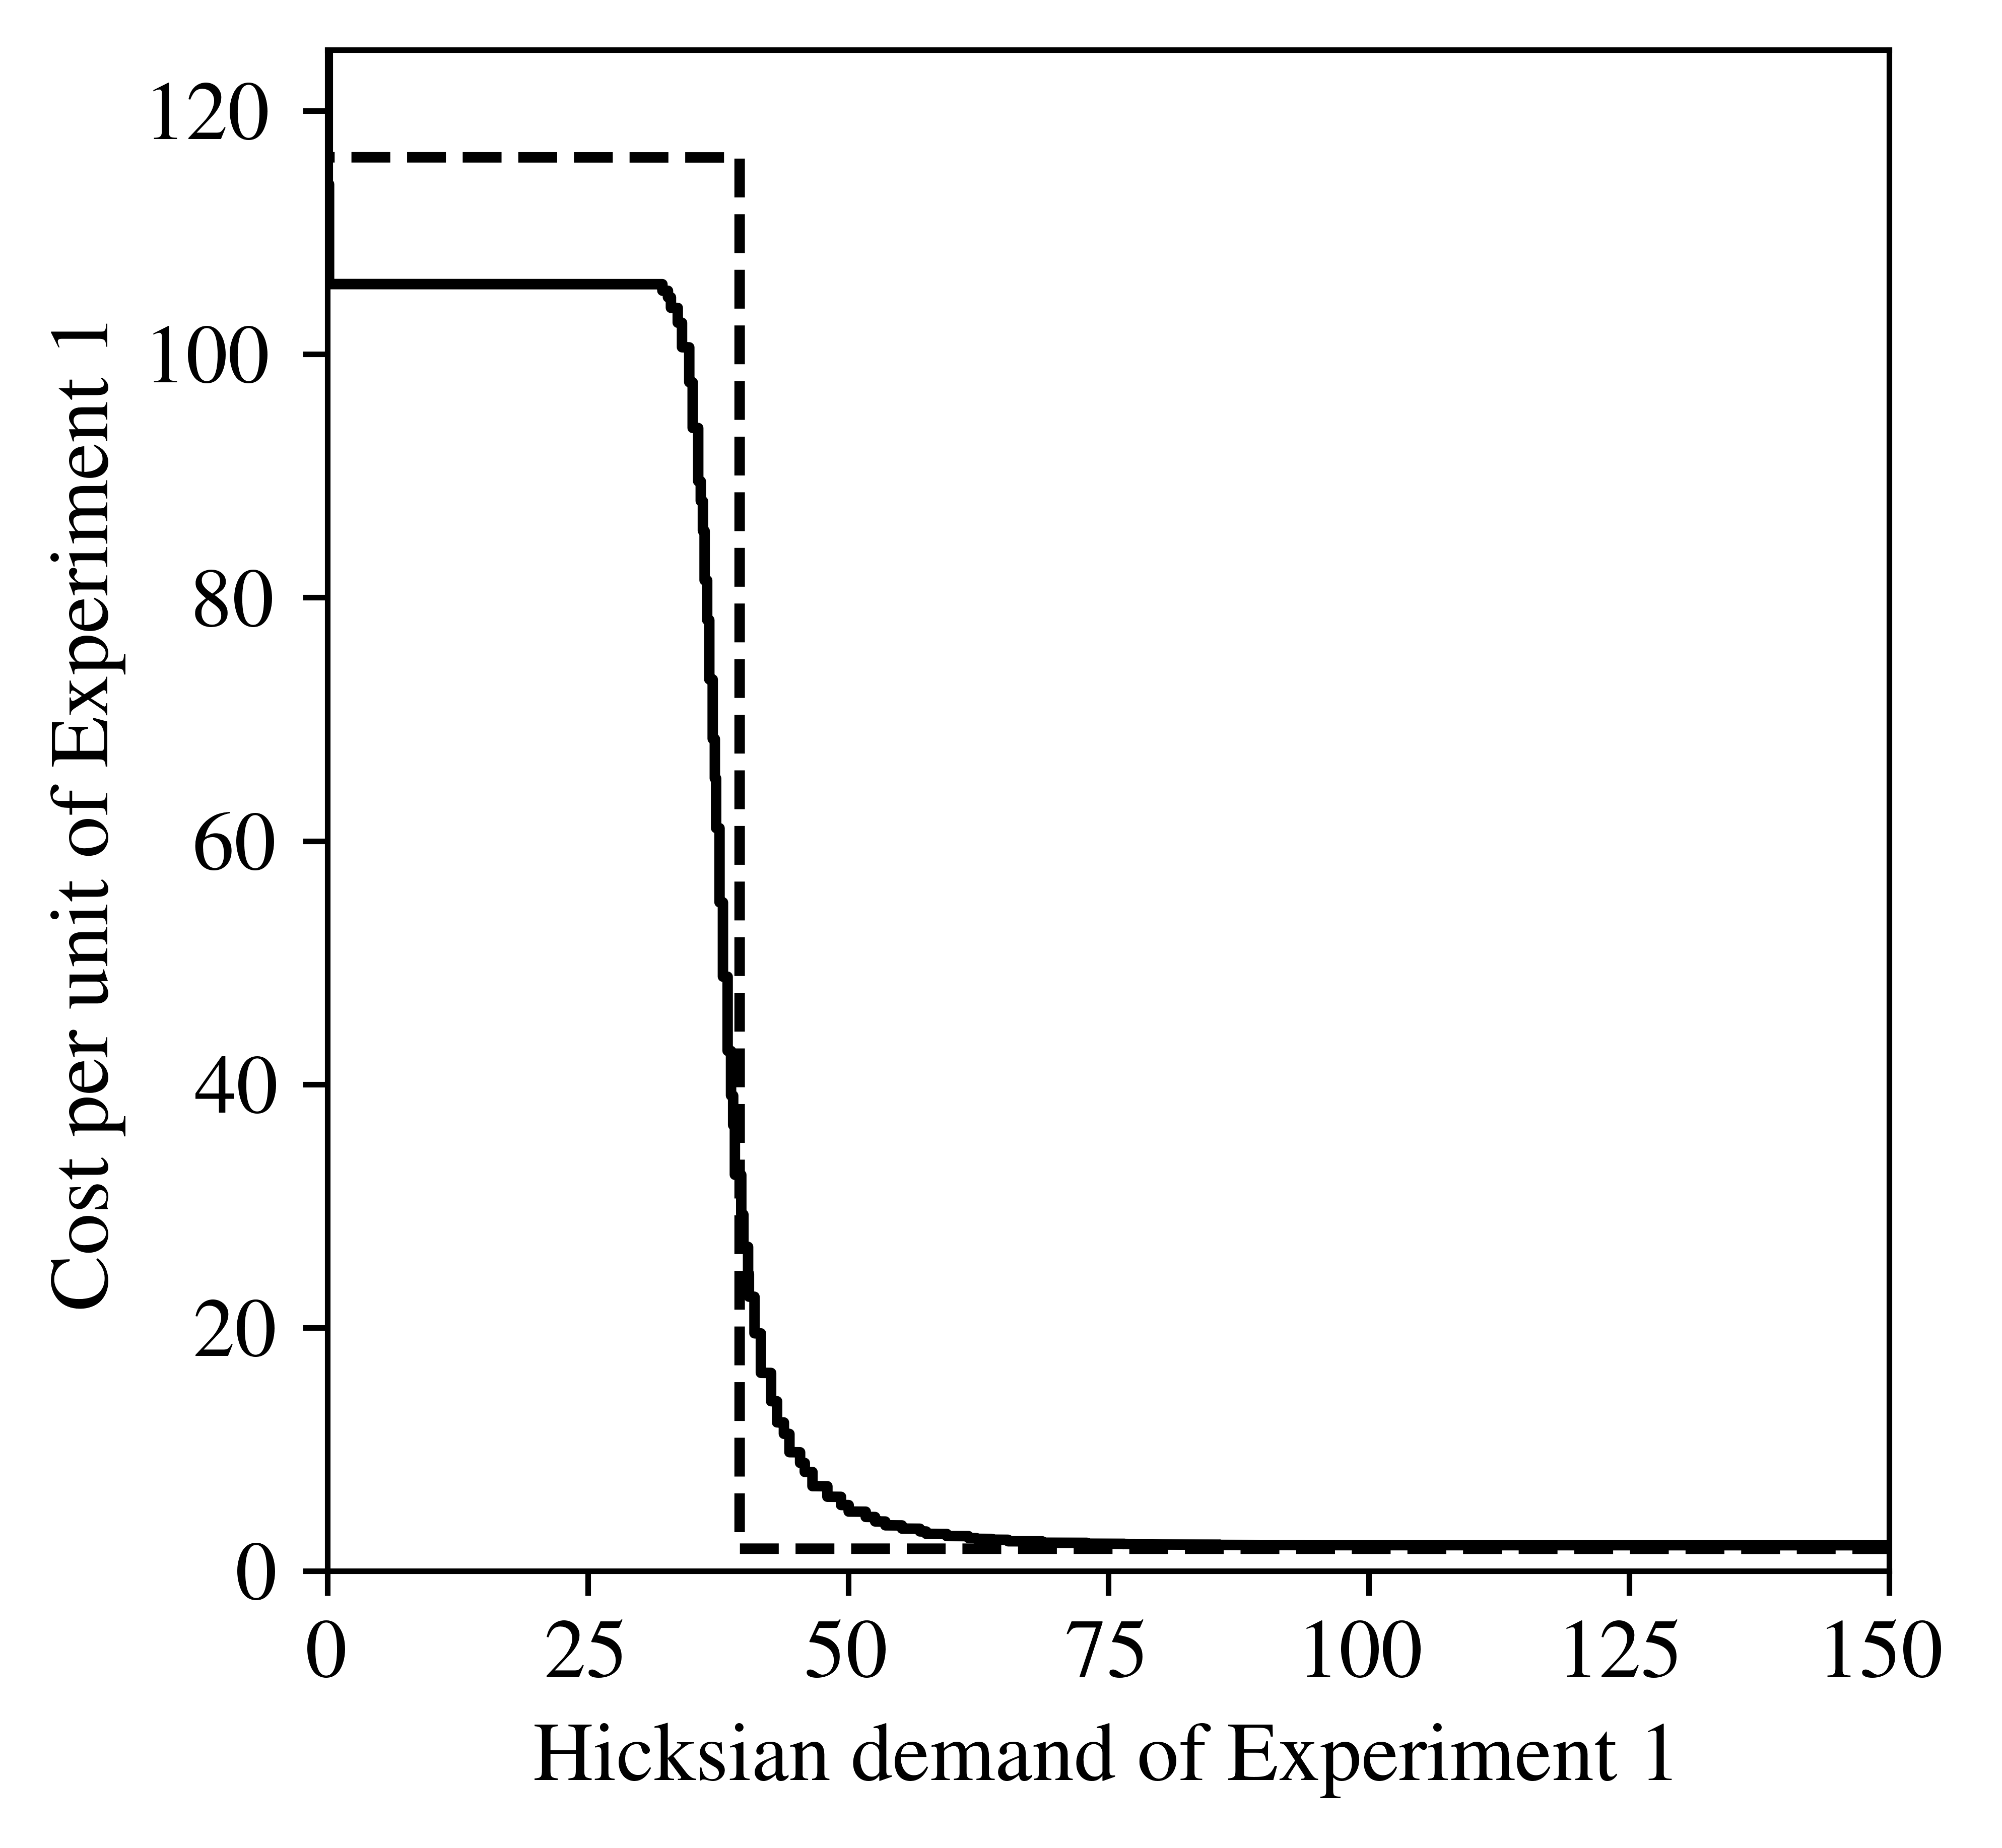

In [233]:
fig = plt.figure(figsize=(4, 4), dpi=1000)
ax = fig.add_subplot(1,1,1)
ax.set_xlim((0, 150))
ax.set_ylim((0, 125))
ax.set_ylabel('Cost per unit of Experiment 1')
ax.set_xlabel('Hicksian demand of Experiment 1')
ax.plot(q1demand,costs1,'k',
        q1approx,costs1,'k--');
plt.savefig('hicksian1.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0,transparent=True)

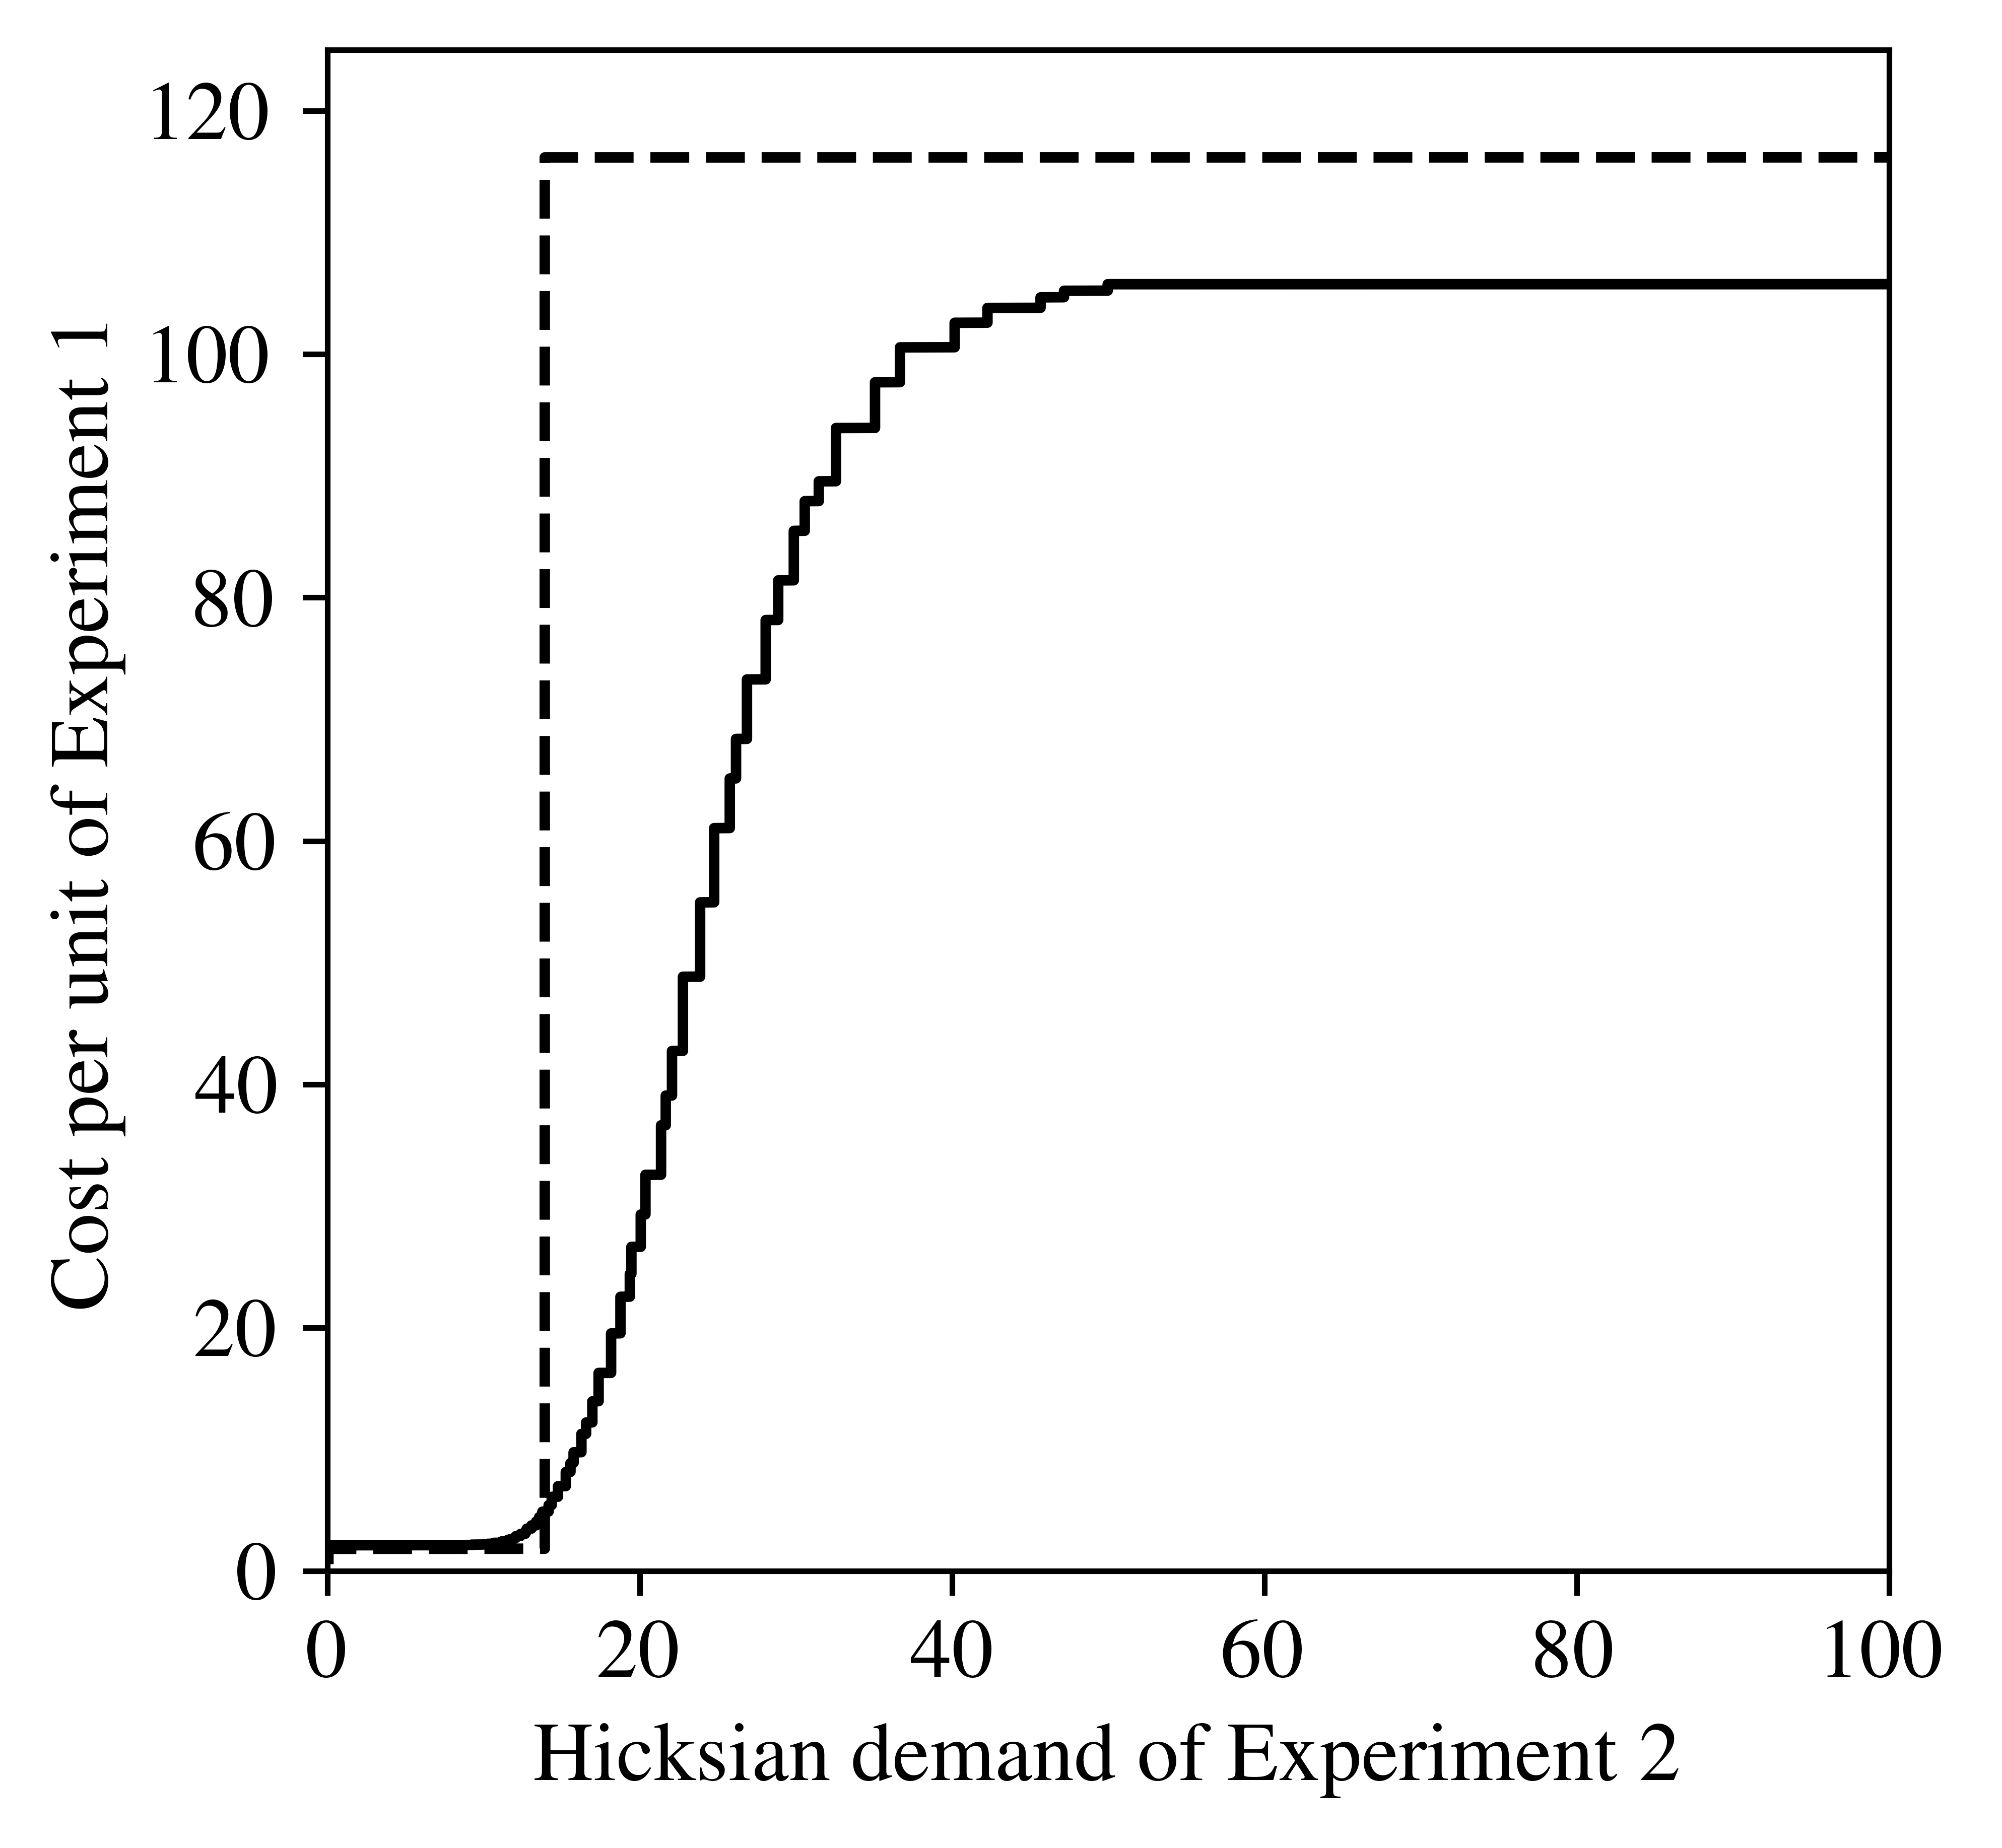

In [234]:
fig = plt.figure(figsize=(4, 4), dpi=1000)
ax = fig.add_subplot(1,1,1)
ax.set_xlim((0, 100))
ax.set_ylim((0, 125))
ax.set_ylabel('Cost per unit of Experiment 1')
ax.set_xlabel('Hicksian demand of Experiment 2')
ax.plot(q2demand,costs1,'k',
        q2approx,costs1,'k--');
plt.savefig('hicksian2.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0,transparent=True)